# BUILDING AN EVALUATION TESTBED

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

This notebook illustrates how to construct closed loop systems for ``NonlinearIOSystem`` elements,
including noise and disturbances.

# Preliminaries

In [25]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML>=0.2.12

import collections
import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [26]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Antimony Model

In [27]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

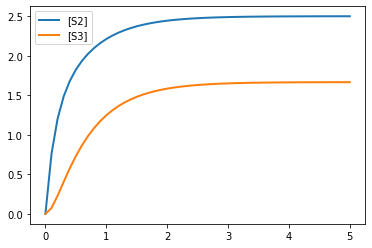

In [28]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 1
k2 = 2
k3 = 3
k4 = 4
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
RR.simulate()
RR.plot()

# Helpers

OK!


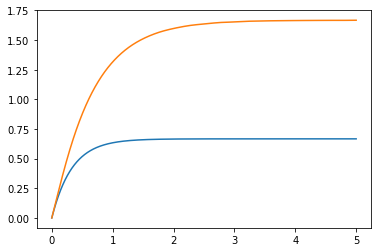

In [29]:
def plotStep(sys, is_plot=True):
    """
    Plots a transfer function step response
    
    Parameters
    ----------
    sys: control.TransferFunction/control.NonlinearIOSystem
    
    Returns
    control.Timeresponse
    """
    if "TransferFunction" in str(type(sys)):
        result = control.forced_response(sys, T=TIMES, U=1)
    elif "NonlinearIOSystem" in str(type(sys)):
        result = control.input_output_response(sys, T=TIMES, U=1)
    if is_plot:
        plt.plot(TIMES, result.outputs.flatten())
    return result

# TESTS
Gs = control.TransferFunction([2], [1, 3])
_ = plotStep(Gs, is_plot=True)
ctlsb = ctl.ControlSBML(MODEL, input_names=["S2"], output_names=["S3"])
ctlsb.set(CONSTANT_DCT)
sys = ctlsb.makeNonlinearIOSystem("sys")
result = plotStep(sys, is_plot=True)
print("OK!")

In [30]:
def pp(obj):
    """
    Does a LaTex rendering of an object with a latex representation.

    Parameters
    ----------
    obj: object
    """
    display(Math(str(obj)))

# Tests
pp(r"e^{\alpha}")

<IPython.core.display.Math object>

# Closed Loop Transfer Functions

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />
     
**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

# Elements of an Evaluation Testbed

## System Under Control

In [31]:
ctlsb = ctl.ControlSBML(MODEL, input_names=["S2"], output_names=["S3"])
SYSTEM = ctlsb.makeNonlinearIOSystem("system")

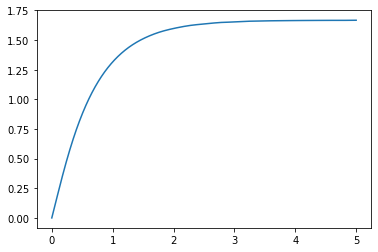

In [32]:
result = control.input_output_response(SYSTEM, T=TIMES, U=1)
plt.plot(result.t, result.y.flatten())

## Noise and Disturbanes

In [33]:
def makeSinusoidSystem(name, amp, frequency):
    """
    Construct a NonlinearIOSystem for a sinusoid.
    The system has output "out".
    
    Parameters
    ----------
    name: str
    amp: float
    frequency: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    def outfcn(time, _, __, ___):
        """
        Creates a sine wave at the frequency specified.

        Parameters
        ----------
        time: float
        """
        return amp*np.sin(time*frequency)
    #
    return control.NonlinearIOSystem(
        None, outfcn, outputs=['out'], inputs=[],
        name=name)

# Tests
sys = makeSinusoidSystem("sine", 10, 20)
result = control.input_output_response(sys, T=TIMES)
assert(len(result.y) > 0)
print("OK!")

OK!


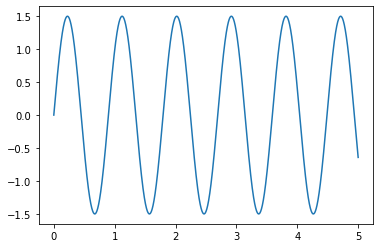

In [34]:
noise = makeSinusoidSystem("noise", 1.5, 7)
result = control.input_output_response(noise, T=TIMES)
plt.plot(result.t, result.y.flatten())

## Controller

In [35]:
def makeController(name, kp):
    """
    Construct a NonlinearIOSystem for a sinusoid.
    The system has output "out".
    
    Parameters
    ----------
    name: str
    kp: float
        proportional control constant
    
    Returns
    -------
    NonlinearIOSystem
    """
    def outfcn(_, __, u_vec, ___):
        """
        Calculate u(t) from e(t), which is the input.

        Parameters
        ----------
        x_vec: array-float
            state
        u_vec: array-float
            input (e(t))

        Returns
        -------
        float
        """
        try:
            u_vec = u_vec[0]
        except:
            pass
        return u_vec*kp
    #
    return control.NonlinearIOSystem(
        None, outfcn, outputs=['out'], inputs=['in'],
        name=name)

# Tests
kp = 0.5
sys = makeController("controller", kp)
control_inputs = [0, 1, 2]
result = control.input_output_response(sys, T=control_inputs, U=control_inputs)
trues = [y == kp*i for y, i in zip(result.y.flatten(), control_inputs)]
assert(all(trues))
print("OK!")

OK!


## Using ``IOSystemFactor``

``ControlSBML`` has capabilities for constructing various ``IOSystem`` objects in ``IOSystemFactory``.

In [37]:
help(ctl.IOSystemFactory)

Help on class IOSystemFactory in module controlSBML.iosystem_factory:

class IOSystemFactory(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  makeAdder(self, name, num_input=2)
 |      Inputs two or more elements. Outputs their sum. Name is "sum".
 |      The inputs are "in1", "in2", ...
 |      The output is "out".
 |      
 |      Parameters
 |      ----------
 |      name: str
 |      
 |      Returns
 |      -------
 |      NonlinearIOSystem
 |  
 |  makeConstant(self, name, constant)
 |      Outputs a constant value.
 |      
 |      Parameters
 |      ----------
 |      name: str
 |      constant: float
 |      
 |      Returns
 |      -------
 |      NonlinearIOSystem
 |  
 |  makeFilter(self, name, constant)
 |      Construct a NonlinearIOSystem for x' = a*x + u, where u is the
 |      filter input.
 |      The system has input "in" and output "out". 
 |      The output is normaliz

**Factories**

  - makeFilter: creates an exponential filter
  - makeConstant: outputs a constant value
  - makeAdder: creates an IOSystem that outputs the sum of the inputs
  - makePassthur: creates an IOSystem that outputs the inpu
  - makePIDController: creates a PID controller
  - makeSinusoid: creates an IOSystem that outputs a sinusoid


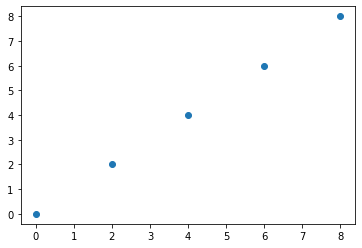

In [41]:
FACTORY = ctl.IOSystemFactory()
controller1 = FACTORY.makePIDController("controller", kp=2)
controller2 = makeController("controller", 2)

times = [0, 1, 2, 3, 4]
result1 = control.input_output_response(controller1, T=times, U=times)
result2 = control.input_output_response(controller2, T=times, U=times)
plt.scatter(result1.y.flatten(), result2.y.flatten())

# Building a Testbed

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

## Create the IOSystem Elements

* $R(s)$: Reference input
* $D(s)$: disturbance
* $N(s)$: noise signal

* $C(s)$: controller
* $G(s)$: system
* $F(s)$: filter

* Summantion of $R(s)$, filter output
* Summantion of $U(s)$, $D(s)$
* Summation of $N(s)$, $Y(s)$

In [61]:
disturbance = makeSinusoidSystem("disturbance", 0, 2)
noise = makeSinusoidSystem("noise", 0, 20)
controller = makeController("controller", 200)
system = ctlsb.makeNonlinearIOSystem("system")
fltr = FACTORY.makeFilter("fltr", -1)
neg_fltr = FACTORY.makeMultiplier("neg_fltr", -1)
sum_R_NF = FACTORY.makeAdder("sum_R_NF")
sum_U_D = FACTORY.makeAdder("sum_U_D")
sum_N_Y = FACTORY.makeAdder("sum_N_Y")

### Solution

In [39]:
ref = 3

# Create the elements of the feedback loop
reference = FACTORY.makeMultiplier("reference", ref)
noise = FACTORY.makeSinusoid("noise", 0.01, 20)
disturbance = FACTORY.makeSinusoid("disturbance", 5, 2)

ctlsb = ctl.ControlSBML(MODEL, input_names=["S2"], output_names=["S3"])
system = ctlsb.makeNonlinearIOSystem("system")
controller = FACTORY.makePIDController("controller", kp=30)
fltr = FACTORY.makeFilter("fltr", -100)

sum_Y_N = FACTORY.makeAdder("sum_Y_N")
sum_U_D = FACTORY.makeAdder("sum_U_D")
sum_R_F = FACTORY.makeAdder("sum_R_F")

## Connect the Elements

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

In [62]:
# Create the closed loop system
closed_loop = control.interconnect(
  [noise, disturbance, sum_N_Y, sum_R_NF, sum_U_D,
  system, fltr, controller, neg_fltr ], 
  connections=[
    ['controller.in', 'sum_R_NF.out'],    # e(t)
    ['sum_R_NF.in1', "neg_fltr.out"],
    ["sum_U_D.in1", "controller.out"],
    ["sum_U_D.in2", "disturbance.out"],
    ["system.S2", "sum_U_D.out"],
    ["sum_N_Y.in1", "system.S3"],
    ["sum_N_Y.in2", "noise.out"],
    ["fltr.in", "sum_N_Y.out"],
    ["neg_fltr.in", "fltr.out"],
    
  ],
  inplist=["sum_R_NF.in2"],
  outlist = ["sum_R_NF.in2", "sum_N_Y.out"]
)

### Solution

In [ ]:
# Create the closed loop system
closed_loop = control.interconnect(
  [reference, noise, disturbance, sum_Y_N, sum_R_F, sum_U_D, system, fltr, controller ], 
  connections=[
    ['controller.in', 'sum_R_F.out'],    # e(t)
    ['sum_U_D.in1', 'controller.out'],   # u(t)
    ['sum_U_D.in2', 'disturbance.out'],  # d(t)
    ['system.S2',   'sum_U_D.out'],
    ['sum_Y_N.in1', 'system.S3'],        # y(t)
    ['sum_Y_N.in2', 'noise.out'],        # n(t)
    ['fltr.in',     'sum_Y_N.out'],
    ['sum_R_F.in1', '-fltr.out'],
    ['sum_R_F.in2', 'reference.out'],
  ],
  inplist=["reference.in"],
  outlist=["disturbance.out", "sum_Y_N.out", 'sum_R_F.out', 'system.S3'],
)

## Simulate

Plot the response of the closed loop system to a unit step response.

### Solution

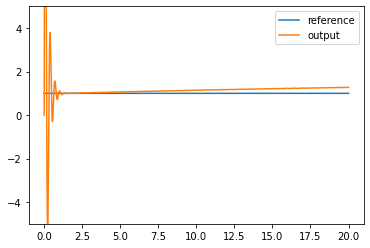

In [63]:
times = ctl.makeSimulationTimes(0, 20, 500)
result = control.input_output_response(closed_loop, T=times, U=1)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())
plt.ylim([-5, 5])
legends = ["reference", "output"]
plt.legend(legends)

The output is biased! We wanted $S_3$ to be 10, but it's 7.6.